In [ ]:
import os
import polars as pl
import dotenv
from tqdm import tqdm
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from scipy import stats
FOLDER_PATH = os.getenv("FOLDER_PATH")


dotenv.load_dotenv()
stock = "WBD"

Python-dotenv could not parse statement starting at line 4
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 10


In [ ]:
parquet_files = [f for f in os.listdir(f"{FOLDER_PATH}{stock}") if f.endswith('.parquet')]
parquet_files.sort()
print(len(parquet_files),"\n",parquet_files)
threshold = len(parquet_files)//10

parquet_files = parquet_files[:threshold]
# Read and concatenate all parquet files
df = pl.concat([
    pl.read_parquet(f"{FOLDER_PATH}{stock}/{file}") 
    for file in parquet_files
])

74 
 ['WBD_2024-07-22.parquet', 'WBD_2024-07-23.parquet', 'WBD_2024-07-24.parquet', 'WBD_2024-07-25.parquet', 'WBD_2024-07-26.parquet', 'WBD_2024-07-29.parquet', 'WBD_2024-07-30.parquet', 'WBD_2024-07-31.parquet', 'WBD_2024-08-01.parquet', 'WBD_2024-08-02.parquet', 'WBD_2024-08-05.parquet', 'WBD_2024-08-06.parquet', 'WBD_2024-08-07.parquet', 'WBD_2024-08-08.parquet', 'WBD_2024-08-09.parquet', 'WBD_2024-08-12.parquet', 'WBD_2024-08-13.parquet', 'WBD_2024-08-14.parquet', 'WBD_2024-08-15.parquet', 'WBD_2024-08-16.parquet', 'WBD_2024-08-19.parquet', 'WBD_2024-08-20.parquet', 'WBD_2024-08-21.parquet', 'WBD_2024-08-22.parquet', 'WBD_2024-08-23.parquet', 'WBD_2024-08-26.parquet', 'WBD_2024-08-27.parquet', 'WBD_2024-08-28.parquet', 'WBD_2024-08-29.parquet', 'WBD_2024-08-30.parquet', 'WBD_2024-09-03.parquet', 'WBD_2024-09-04.parquet', 'WBD_2024-09-05.parquet', 'WBD_2024-09-06.parquet', 'WBD_2024-09-09.parquet', 'WBD_2024-09-10.parquet', 'WBD_2024-09-11.parquet', 'WBD_2024-09-12.parquet', 'WBD_2

In [ ]:
def curate_mid_price(df,stock):
    num_entries_by_publisher = df.group_by("publisher_id").len().sort("len", descending=True)
    if len(num_entries_by_publisher) > 1:
            df = df.filter(pl.col("publisher_id") == 41)
        
        
    if stock == "GOOGL":
        df = df.filter(pl.col("ts_event").dt.hour() >= 13)
        df = df.filter(pl.col("ts_event").dt.hour() <= 20)
        
        
    else:
        df = df.filter(
            (
                (pl.col("ts_event").dt.hour() == 9) & (pl.col("ts_event").dt.minute() >= 35) |
                (pl.col("ts_event").dt.hour() > 9) & (pl.col("ts_event").dt.hour() < 16)
            )
        )
    
    # Remove the first row at 9:30
    df = df.with_row_index("index").filter(
        ~((pl.col("ts_event").dt.hour() == 9) & 
          (pl.col("ts_event").dt.minute() == 30) & 
          (pl.col("index") == df.filter(
              (pl.col("ts_event").dt.hour() == 9) & 
              (pl.col("ts_event").dt.minute() == 30)
          ).with_row_index("index").select("index").min())
        )
    ).drop("index")
    mid_price = (df["ask_px_00"] + df["bid_px_00"]) / 2
    
    
    # managing nans or infs, preceding value filling
    mid_price = mid_price.fill_nan(mid_price.shift(1))
    df = df.with_columns(mid_price=mid_price)
    # now we define the mid price with the microprice, barycenter of bid and ask prices by their weights
    
    micro_price = (df["ask_px_00"] * df["bid_sz_00"] + df["bid_px_00"] * df["ask_sz_00"]) / (df["bid_sz_00"] + df["ask_sz_00"])
    df = df.with_columns(micro_price=micro_price)
    # sort by ts_event
    df = df.sort("ts_event")
    return df

In [ ]:
df  = curate_mid_price(df,stock)

# average bid ask spread
avg_spread = (df["ask_px_00"] - df["bid_px_00"]).mean()

In [ ]:
print(f"Average bid ask spread: {avg_spread}")

Average bid ask spread: 0.01083067877095691


In [ ]:
df.head()

ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,bid_px_01,ask_px_01,bid_sz_01,ask_sz_01,bid_ct_01,ask_ct_01,bid_px_02,ask_px_02,bid_sz_02,ask_sz_02,bid_ct_02,ask_ct_02,bid_px_03,ask_px_03,bid_sz_03,ask_sz_03,bid_ct_03,ask_ct_03,bid_px_04,…,bid_ct_04,ask_ct_04,bid_px_05,ask_px_05,bid_sz_05,ask_sz_05,bid_ct_05,ask_ct_05,bid_px_06,ask_px_06,bid_sz_06,ask_sz_06,bid_ct_06,ask_ct_06,bid_px_07,ask_px_07,bid_sz_07,ask_sz_07,bid_ct_07,ask_ct_07,bid_px_08,ask_px_08,bid_sz_08,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol,date,ts_recv,mid_price,micro_price
"datetime[ns, US/Eastern]",u8,u16,u32,str,str,u8,f64,u32,u8,i32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,…,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,str,date,"datetime[ns, UTC]",f64,f64
2024-07-22 09:35:00.001689461 EDT,10,2,17256,"""C""","""B""",1,8.5,1200,130,166251,30418076,8.51,8.52,200,3149,1,7,8.5,8.53,4380,5667,10,12,8.49,8.54,5592,5712,10,8,8.48,8.55,4749,5304,9,8,8.47,…,9,6,8.46,8.57,12888,805,12,3,8.45,8.58,1085,1700,8,5,8.44,8.59,454,302,4,4,8.43,8.6,113,1066,2,6,8.42,8.62,352,110,4,1,"""WBD""",2024-07-22,2024-07-22 13:35:00.001855712 UTC,8.515,8.510597
2024-07-22 09:35:00.001985212 EDT,10,2,17256,"""C""","""B""",1,8.5,1400,130,165477,30418188,8.51,8.52,200,3149,1,7,8.5,8.53,2980,5667,9,12,8.49,8.54,5592,5712,10,8,8.48,8.55,4749,5304,9,8,8.47,…,9,6,8.46,8.57,12888,805,12,3,8.45,8.58,1085,1700,8,5,8.44,8.59,454,302,4,4,8.43,8.6,113,1066,2,6,8.42,8.62,352,110,4,1,"""WBD""",2024-07-22,2024-07-22 13:35:00.002150689 UTC,8.515,8.510597
2024-07-22 09:35:00.029098385 EDT,10,2,17256,"""A""","""B""",3,8.48,24,130,165997,30425918,8.51,8.52,200,3149,1,7,8.5,8.53,2980,5667,9,12,8.49,8.54,5592,5712,10,8,8.48,8.55,4773,5304,10,8,8.47,…,9,6,8.46,8.57,12888,805,12,3,8.45,8.58,1085,1700,8,5,8.44,8.59,454,302,4,4,8.43,8.6,113,1066,2,6,8.42,8.62,352,110,4,1,"""WBD""",2024-07-22,2024-07-22 13:35:00.029264382 UTC,8.515,8.510597
2024-07-22 09:35:00.217015369 EDT,10,2,17256,"""T""","""N""",0,8.515,13,130,166957,30444216,8.51,8.52,200,3149,1,7,8.5,8.53,2980,5667,9,12,8.49,8.54,5592,5712,10,8,8.48,8.55,4773,5304,10,8,8.47,…,9,6,8.46,8.57,12888,805,12,3,8.45,8.58,1085,1700,8,5,8.44,8.59,454,302,4,4,8.43,8.6,113,1066,2,6,8.42,8.62,352,110,4,1,"""WBD""",2024-07-22,2024-07-22 13:35:00.217182326 UTC,8.515,8.510597
2024-07-22 09:35:00.217059151 EDT,10,2,17256,"""A""","""A""",0,8.52,500,130,165580,30444220,8.51,8.52,200,3649,1,8,8.5,8.53,2980,5667,9,12,8.49,8.54,5592,5712,10,8,8.48,8.55,4773,5304,10,8,8.47,…,9,6,8.46,8.57,12888,805,12,3,8.45,8.58,1085,1700,8,5,8.44,8.59,454,302,4,4,8.43,8.6,113,1066,2,6,8.42,8.62,352,110,4,1,"""WBD""",2024-07-22,2024-07-22 13:35:00.217224731 UTC,8.515,8.51052


In [ ]:
df_cleaned = df[["ts_event","mid_price"]]

In [ ]:
df_cleaned = df[["ts_event","mid_price","micro_price"]]

Average arrival time

Average time between mid price changes: shape: (1, 1)
┌──────────────┐
│ time_diff_ms │
│ ---          │
│ f64          │
╞══════════════╡
│ 2041.576279  │
└──────────────┘


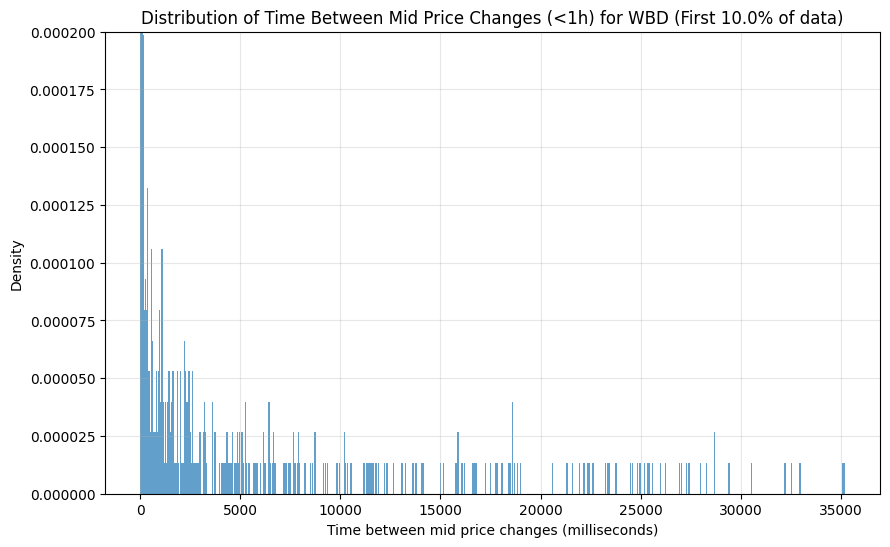

In [ ]:
# Compute average time between mid price changes
import numpy as np
import matplotlib.pyplot as plt

# Calculate time differences between mid price changes in nanoseconds and convert to milliseconds
time_diffs = df.with_columns(
    mid_price_change=pl.col("mid_price").diff()
).filter(
    pl.col("mid_price_change") != 0
).select(
    (pl.col("ts_event").diff().cast(pl.Int64) / 1_000_000).alias("time_diff_ms")  # Convert to milliseconds
).drop_nulls()

# Filter out times > 1 hour (3600000 milliseconds) 
time_diffs = time_diffs.filter(pl.col("time_diff_ms") <= 36000)

# Take first alpha fraction of data
alpha = 0.1  # Use first 10% of data
time_diffs_np = time_diffs.to_numpy().flatten()[:int(len(time_diffs) * alpha)]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(time_diffs_np, bins='auto', density=True, alpha=0.7)

plt.title(f'Distribution of Time Between Mid Price Changes (<1h) for {stock} (First {alpha*100}% of data)')
plt.xlabel('Time between mid price changes (milliseconds)')
plt.ylabel('Density')
plt.ylim(0,0.0002)
print('Average time between mid price changes:', time_diffs.mean())
avg_arrival_time = time_diffs.mean()["time_diff_ms"][0] 
plt.grid(True, alpha=0.3)

In [ ]:

# Save plot
os.makedirs(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/", exist_ok=True)
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_arrival_times.png")


<Figure size 640x480 with 0 Axes>

In [ ]:
time_scales = [str(int(k*avg_arrival_time))+"us" for k in [1,5,10,30,100,1000,3000,10000,30000,100000,300000,1000000,3000000]]
print(time_scales)

['2041us', '10207us', '20415us', '61247us', '204157us', '2041576us', '6124728us', '20415762us', '61247288us', '204157627us', '612472883us', '2041576279us', '6124728837us']


In [ ]:
time_scales = time_scales

dfs = {}

for scale in time_scales:
    df_temp = df_cleaned.group_by(pl.col("ts_event").dt.truncate(scale)).agg([
        pl.col("mid_price").last().alias("mid_price")
    ])
    
    df_temp = df_temp.sort("ts_event")
    
    df_temp = df_temp.with_columns(
        tick_variation=pl.when(pl.col("ts_event").dt.date().diff() == 0)
        .then(pl.col("mid_price").diff()/avg_spread)
        .otherwise(None)
    )
    df_temp = df_temp.with_columns(
        log_variation=pl.when(pl.col("ts_event").dt.date().diff() == 0)
        .then(pl.col("mid_price").log().diff())
        .otherwise(None)
    )
    
    dfs[scale] = df_temp
    
    print(f"\n{scale} sampling:")
    print(df_temp.head())


2041us sampling:
shape: (5, 4)
┌────────────────────────────────┬───────────┬────────────────┬───────────────┐
│ ts_event                       ┆ mid_price ┆ tick_variation ┆ log_variation │
│ ---                            ┆ ---       ┆ ---            ┆ ---           │
│ datetime[ns, US/Eastern]       ┆ f64       ┆ f64            ┆ f64           │
╞════════════════════════════════╪═══════════╪════════════════╪═══════════════╡
│ 2024-07-22 09:35:00.000229 EDT ┆ 8.515     ┆ null           ┆ null          │
│ 2024-07-22 09:35:00.028803 EDT ┆ 8.515     ┆ 0.0            ┆ 0.0           │
│ 2024-07-22 09:35:00.216575 EDT ┆ 8.505     ┆ -0.923303      ┆ -0.001175     │
│ 2024-07-22 09:35:00.218616 EDT ┆ 8.505     ┆ 0.0            ┆ 0.0           │
│ 2024-07-22 09:35:00.220657 EDT ┆ 8.505     ┆ 0.0            ┆ 0.0           │
└────────────────────────────────┴───────────┴────────────────┴───────────────┘

10207us sampling:
shape: (5, 4)
┌────────────────────────────────┬───────────┬─────────

In [ ]:
"""
import plotly.graph_objects as go

# Create plots for each time scale
for scale in time_scales:
    df_current = dfs[scale]
    
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=df_current["ts_event"], y=df_current["mid_price"], name="Mid Price")
    )
    fig.update_layout(
        title=f"{scale} Sampling",
        xaxis_title="Time", 
        yaxis_title="Mid Price"
    )
    fig.show()
"""

'\nimport plotly.graph_objects as go\n\n# Create plots for each time scale\nfor scale in time_scales:\n    df_current = dfs[scale]\n    \n    fig = go.Figure()\n    fig.add_trace(\n        go.Scatter(x=df_current["ts_event"], y=df_current["mid_price"], name="Mid Price")\n    )\n    fig.update_layout(\n        title=f"{scale} Sampling",\n        xaxis_title="Time", \n        yaxis_title="Mid Price"\n    )\n    fig.show()\n'

In [ ]:
# Calculate volatility under Bachelier model
# In Bachelier model, log returns are normally distributed with variance = sigma^2 * dt
# So sigma = sqrt(var(log returns) / dt)
for scale in time_scales:
    df_current = dfs[scale]
    
    # Add time difference column in seconds by converting nanoseconds to seconds
    df_current = df_current.with_columns(
        dt=pl.col("ts_event").diff().cast(pl.Int64) / 1e9  # Convert directly to seconds
    )
    
    # Calculate volatility using log variations and time differences, normalized by avg_spread
    df_current = df_current.with_columns(
        vol_bachelier=pl.when(pl.col("tick_variation").is_not_null())
        .then((pl.col("tick_variation").abs() / pl.col("dt").sqrt()) / avg_spread)
        .otherwise(None)
    )
    
    dfs[scale] = df_current
    
    # Print summary statistics
    print(f"\nBachelier volatility stats for {scale} sampling:")
    print(df_current.select("vol_bachelier").describe())


Bachelier volatility stats for 2041us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ vol_bachelier │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 315381.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 11.251695     │
│ std        ┆ 118.937541    │
│ min        ┆ 0.0           │
│ 25%        ┆ 0.0           │
│ 50%        ┆ 0.0           │
│ 75%        ┆ 0.0           │
│ max        ┆ 4717.448372   │
└────────────┴───────────────┘

Bachelier volatility stats for 10207us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ vol_bachelier │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 255789.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 5.192247      │
│ std        ┆ 53.256974     │
│ min        ┆ 0.0           │
│ 25%        ┆ 0.0           │
│ 50%        ┆ 0.0           │
│ 75%        ┆ 0.0           │
│ max

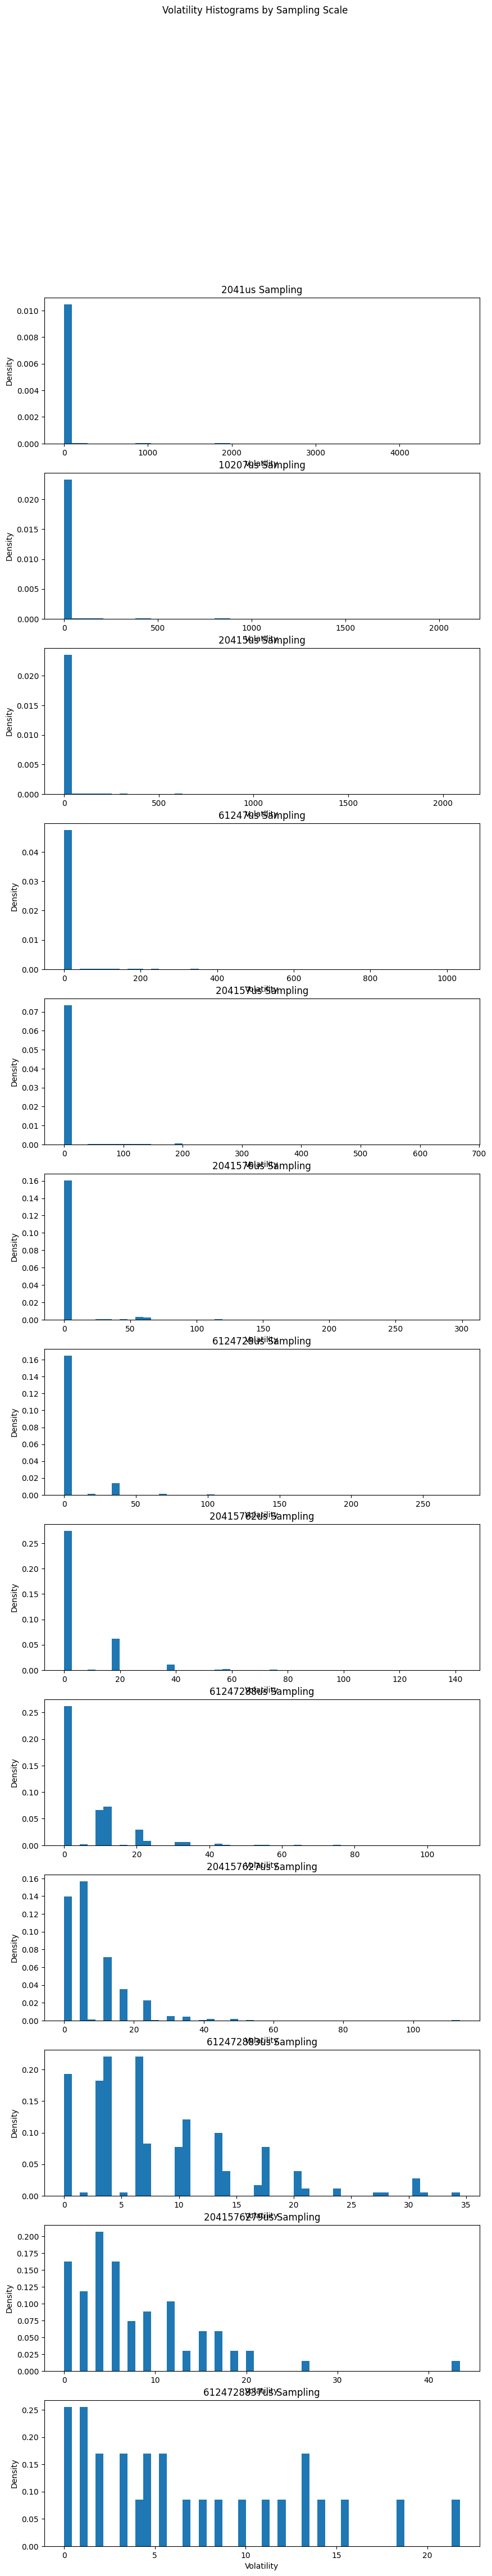

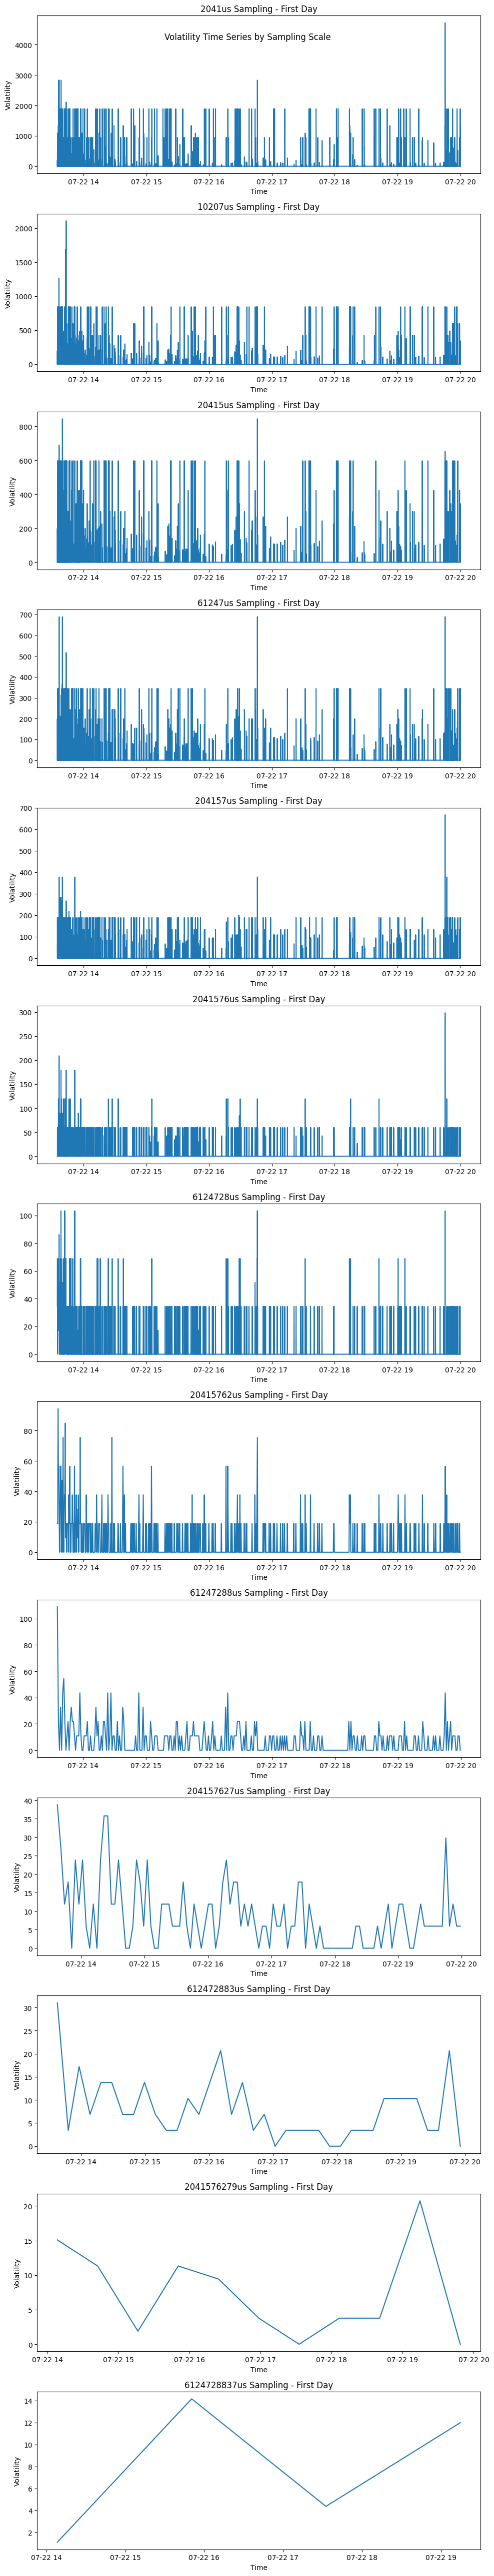

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot histograms and time series of volatility for each sampling scale
import matplotlib.pyplot as plt

# Create subplots for histograms
fig_hist, axes_hist = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_hist.suptitle('Volatility Histograms by Sampling Scale')

# Create subplots for time series
fig_ts, axes_ts = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_ts.suptitle('Volatility Time Series by Sampling Scale')

for i, scale in enumerate(time_scales):
    df_current = dfs[scale]
    
    # Plot histogram
    vol_data = df_current.select('vol_bachelier').to_numpy().flatten()
    axes_hist[i].hist(vol_data[~np.isnan(vol_data)], bins=50, density=True)  # Remove NaN values
    axes_hist[i].set_title(f'{scale} Sampling')
    axes_hist[i].set_xlabel('Volatility')
    axes_hist[i].set_ylabel('Density')
    
    # Plot time series - first day only
    first_day = df_current.select('ts_event').to_numpy()[0].astype('datetime64[D]')
    mask = df_current.select('ts_event').to_numpy().astype('datetime64[D]') == first_day
    
    axes_ts[i].plot(df_current.select('ts_event').to_numpy()[mask], 
                    df_current.select('vol_bachelier').to_numpy()[mask])
    axes_ts[i].set_title(f'{scale} Sampling - First Day')
    axes_ts[i].set_xlabel('Time') 
    axes_ts[i].set_ylabel('Volatility')

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_volatility_histograms_{threshold}.png")

In [ ]:
# Calculate volatility under Bachelier model
# In Bachelier model, log returns are normally distributed with variance = sigma^2 * dt
# So sigma = sqrt(var(log returns) / dt)
for scale in time_scales:
    df_current = dfs[scale]
    
    # Add time difference column in seconds by converting nanoseconds to seconds
    df_current = df_current.with_columns(
        dt=pl.col("ts_event").diff().cast(pl.Int64) / 1e9  # Convert directly to seconds
    )
    
    # Calculate volatility using log variations and time differences, normalized by avg_spread
    df_current = df_current.with_columns(
        vol_bachelier=pl.when(pl.col("log_variation").is_not_null())
        .then((pl.col("log_variation").abs() / pl.col("dt").sqrt()) / avg_spread)
        .otherwise(None)
    )
    
    dfs[scale] = df_current
    
    # Print summary statistics
    print(f"\nBachelier volatility stats for {scale} sampling:")
    print(df_current.select("log_variation").describe())


Bachelier volatility stats for 2041us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ log_variation │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 315381.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 2.4328e-7     │
│ std        ┆ 0.000128      │
│ min        ┆ -0.002569     │
│ 25%        ┆ 0.0           │
│ 50%        ┆ 0.0           │
│ 75%        ┆ 0.0           │
│ max        ┆ 0.003006      │
└────────────┴───────────────┘

Bachelier volatility stats for 10207us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ log_variation │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 255789.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 2.9996e-7     │
│ std        ┆ 0.000143      │
│ min        ┆ -0.002569     │
│ 25%        ┆ 0.0           │
│ 50%        ┆ 0.0           │
│ 75%        ┆ 0.0           │
│ max

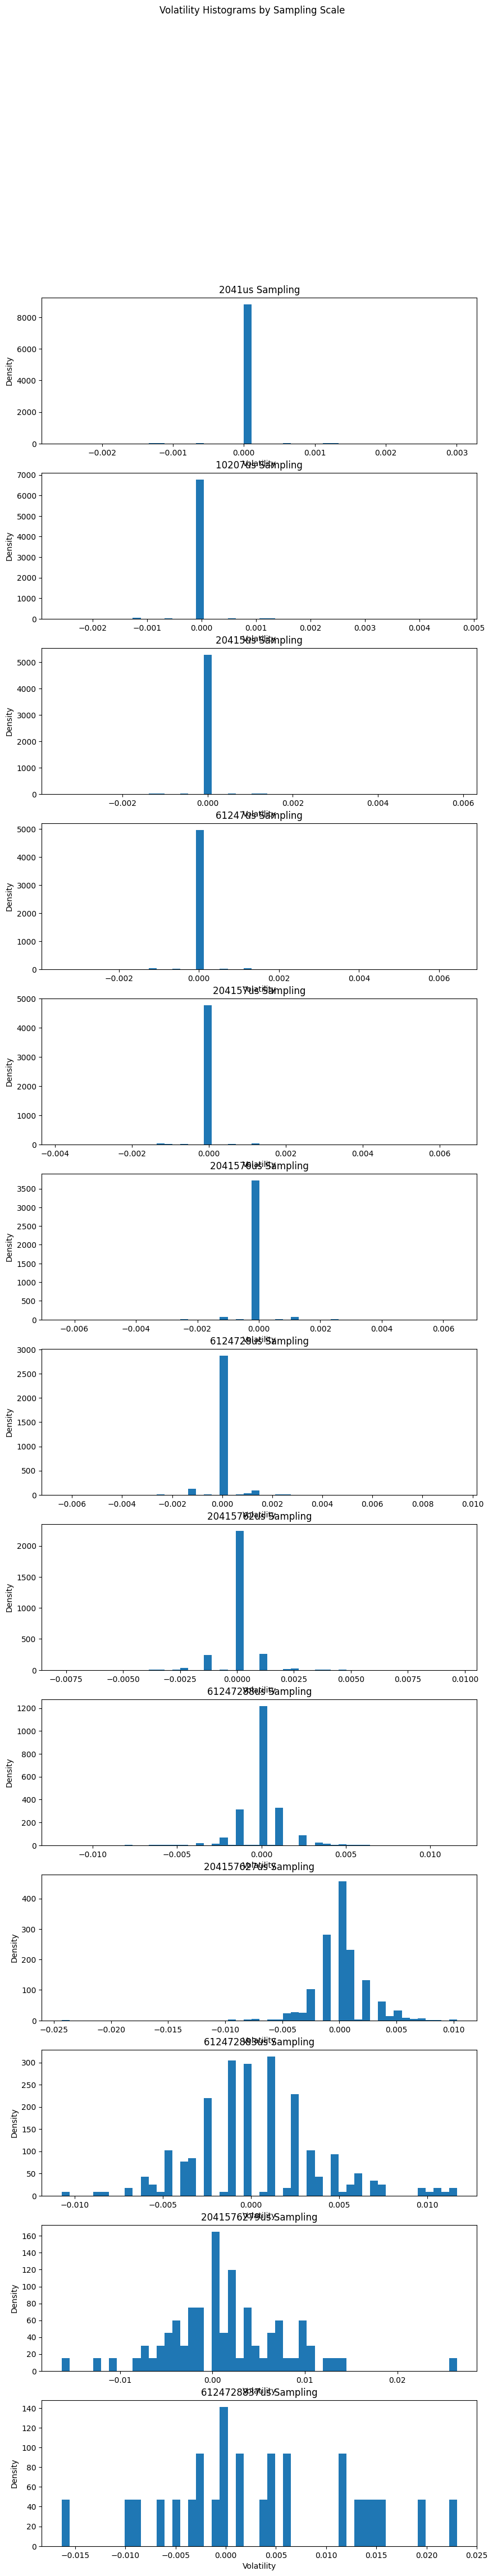

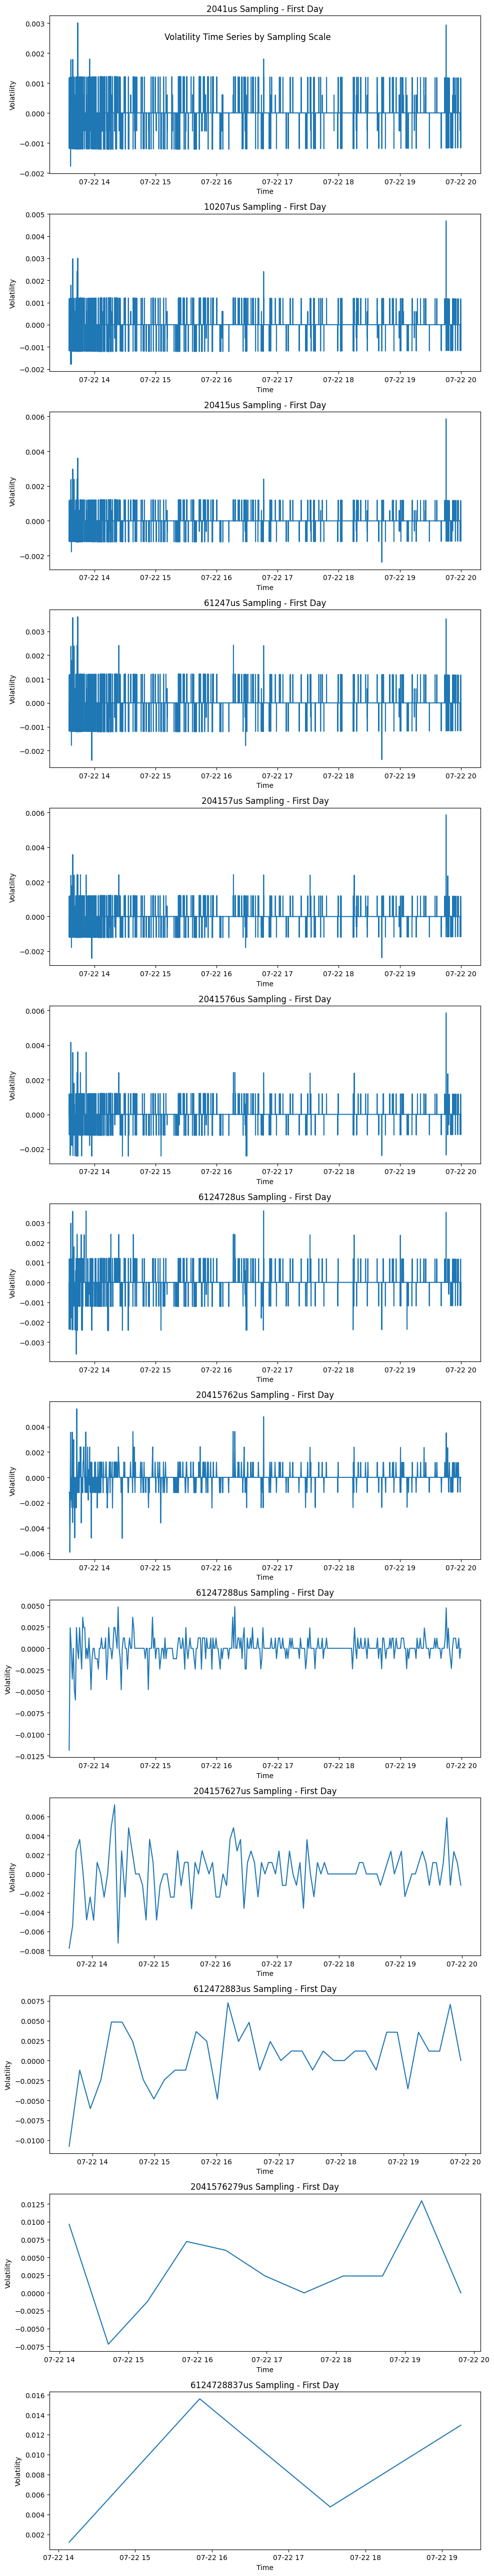

In [ ]:
# Plot histograms and time series of volatility for each sampling scale
import matplotlib.pyplot as plt

# Create subplots for histograms
fig_hist, axes_hist = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_hist.suptitle('Volatility Histograms by Sampling Scale')

# Create subplots for time series
fig_ts, axes_ts = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_ts.suptitle('Volatility Time Series by Sampling Scale')

for i, scale in enumerate(time_scales):
    df_current = dfs[scale]
    
    # Plot histogram
    vol_data = df_current.select('log_variation').to_numpy().flatten()
    axes_hist[i].hist(vol_data[~np.isnan(vol_data)], bins=50, density=True)  # Remove NaN values
    axes_hist[i].set_title(f'{scale} Sampling')
    axes_hist[i].set_xlabel('Volatility')
    axes_hist[i].set_ylabel('Density')
    
    # Plot time series - first day only
    first_day = df_current.select('ts_event').to_numpy()[0].astype('datetime64[D]')
    mask = df_current.select('ts_event').to_numpy().astype('datetime64[D]') == first_day
    
    axes_ts[i].plot(df_current.select('ts_event').to_numpy()[mask], 
                    df_current.select('log_variation').to_numpy()[mask])
    axes_ts[i].set_title(f'{scale} Sampling - First Day')
    axes_ts[i].set_xlabel('Time') 
    axes_ts[i].set_ylabel('Volatility')

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_volatility_histograms_{threshold}.png")
plt.close("all")

In [ ]:
for scale in time_scales:
    # describe all columns
    print(dfs[scale].describe())

shape: (9, 7)
┌────────────┬──────────────┬───────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ statistic  ┆ ts_event     ┆ mid_price ┆ tick_variati ┆ log_variatio ┆ dt           ┆ vol_bacheli │
│ ---        ┆ ---          ┆ ---       ┆ on           ┆ n            ┆ ---          ┆ er          │
│ str        ┆ str          ┆ f64       ┆ ---          ┆ ---          ┆ f64          ┆ ---         │
│            ┆              ┆           ┆ f64          ┆ f64          ┆              ┆ f64         │
╞════════════╪══════════════╪═══════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ count      ┆ 315388       ┆ 315388.0  ┆ 315381.0     ┆ 315381.0     ┆ 315387.0     ┆ 315381.0    │
│ null_count ┆ 0            ┆ 0.0       ┆ 7.0          ┆ 7.0          ┆ 1.0          ┆ 7.0         │
│ mean       ┆ 2024-07-26   ┆ 8.403085  ┆ 0.000187     ┆ 2.4328e-7    ┆ 2.264837     ┆ 0.014589    │
│            ┆ 03:05:14.547 ┆           ┆              ┆              ┆      

In [ ]:
time_scales = time_scales[::-1]

In [ ]:
#plot autocorrelation of log variations

for scale in tqdm(time_scales[::-1], "Calculating autocorrelation for each scale"):
    # to npy and remove nans
    print(scale)
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    n = len(log_var)
    lags = np.arange(n)
    autocorr = np.array([np.corrcoef(log_var[:-lag], log_var[lag:])[0,1] if lag > 0 else 1 for lag in lags])

    plt.plot(lags, autocorr)
    plt.title(f"Autocorrelation of Log Variations - {scale} Sampling")
    plt.xlabel("Lag")
    plt.grid()
    plt.ylabel("Autocorrelation")
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_autocorrelation_{scale}log_var_vanilla.png")

Calculating autocorrelation for each scale:   0%|          | 0/13 [00:00<?, ?it/s]

2041us


Calculating autocorrelation for each scale:   0%|          | 0/13 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#plot autocorrelation of log variations

for scale in tqdm(time_scales[::-1], "Calculating autocorrelation for each scale"):
    # to npy and remove nans
    print(scale)
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    log_var = log_var * log_var
    n = len(log_var)
    lags = np.arange(n)
    autocorr = np.array([np.corrcoef(log_var[:-lag], log_var[lag:])[0,1] if lag > 0 else 1 for lag in lags])

    plt.plot(lags[:min(500,len(lags)//5)], autocorr[:min(500,len(lags)//5)])
    plt.title(f"Autocorrelation of Log Variations - {scale} Sampling")
    plt.xlabel("Lag")
    plt.grid()
    plt.yscale("log")
    plt.ylabel("Autocorrelation")
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_autocorrelation_{scale}_squared_logvar_betterviz_500_log.png")

Calculating autocorrelation for each scale:   0%|          | 0/13 [00:00<?, ?it/s]

2041us


Calculating autocorrelation for each scale:   0%|          | 0/13 [00:02<?, ?it/s]


KeyboardInterrupt: 

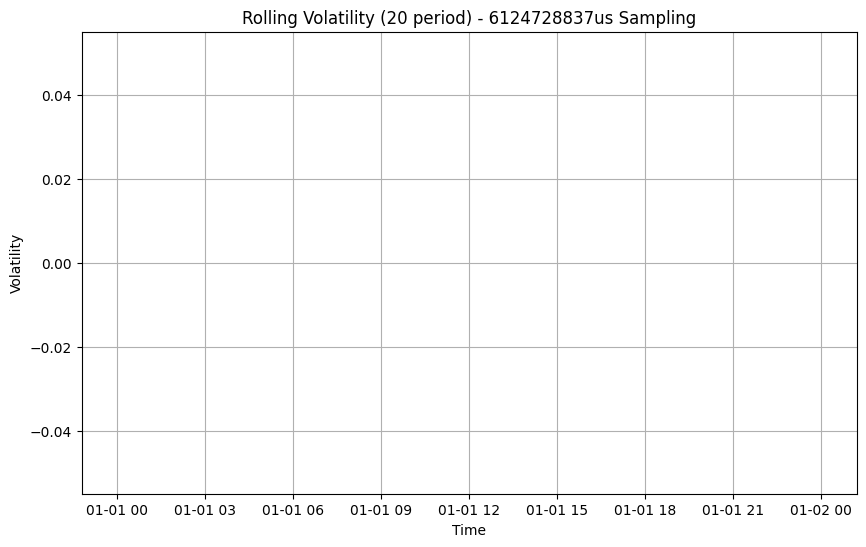

<Figure size 640x480 with 0 Axes>

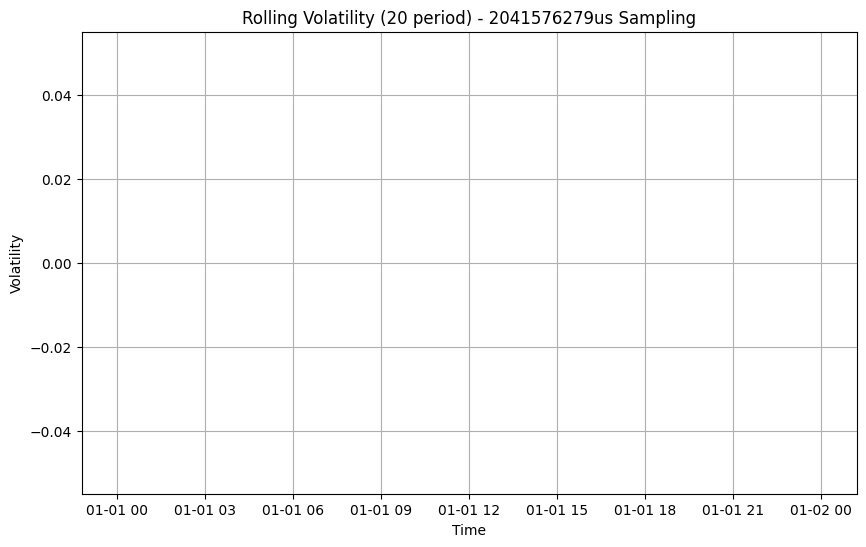

<Figure size 640x480 with 0 Axes>

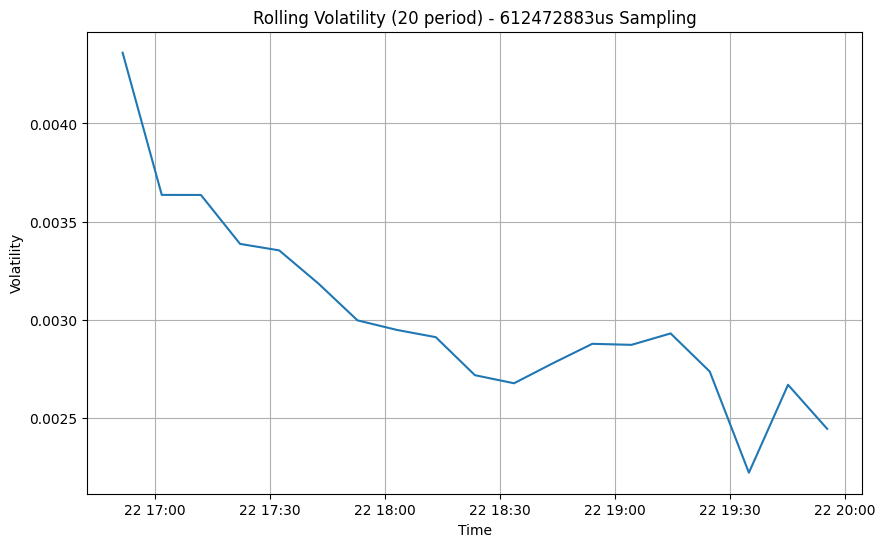

<Figure size 640x480 with 0 Axes>

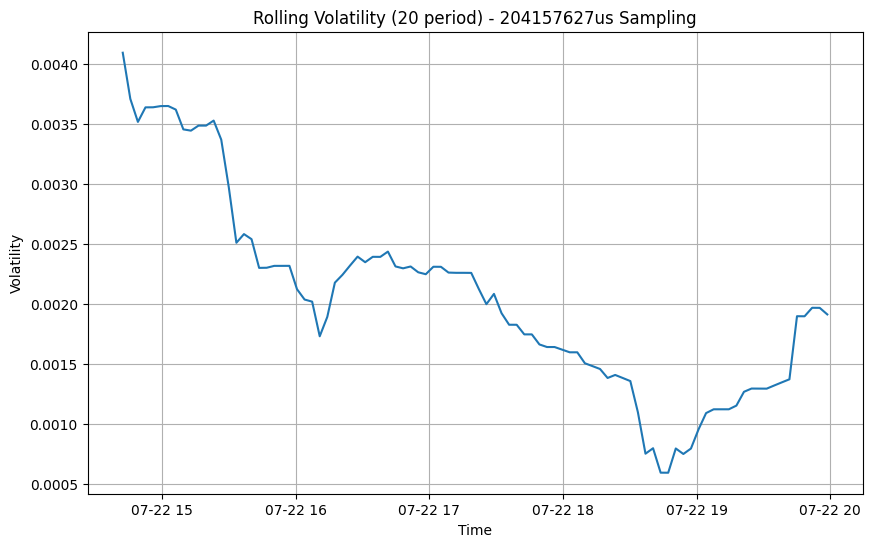

<Figure size 640x480 with 0 Axes>

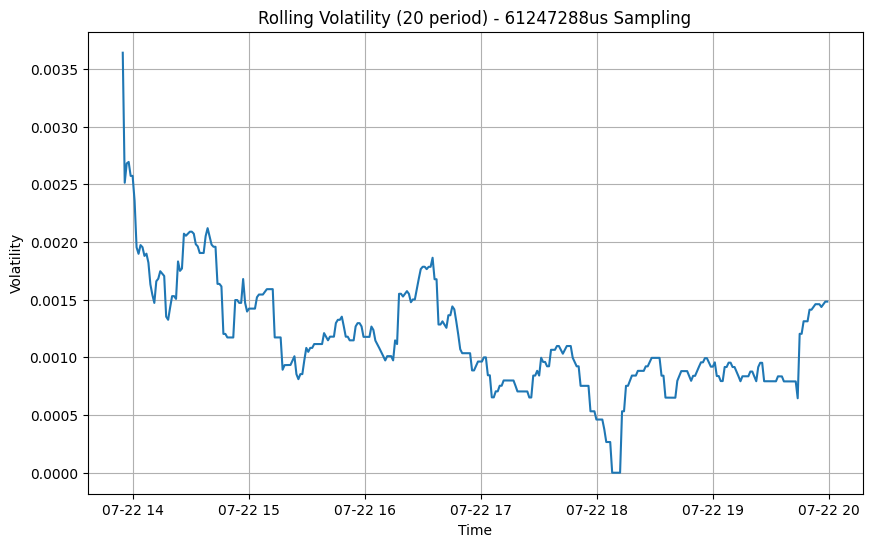

<Figure size 640x480 with 0 Axes>

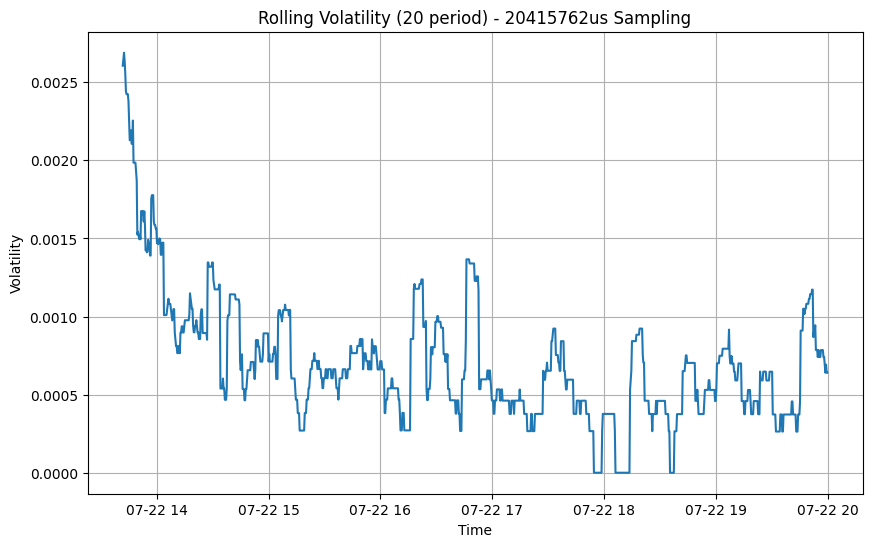

<Figure size 640x480 with 0 Axes>

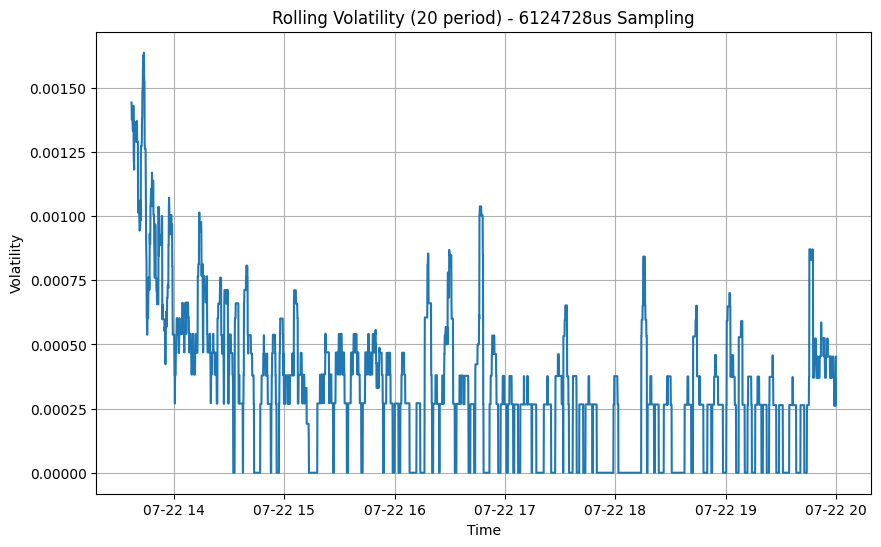

<Figure size 640x480 with 0 Axes>

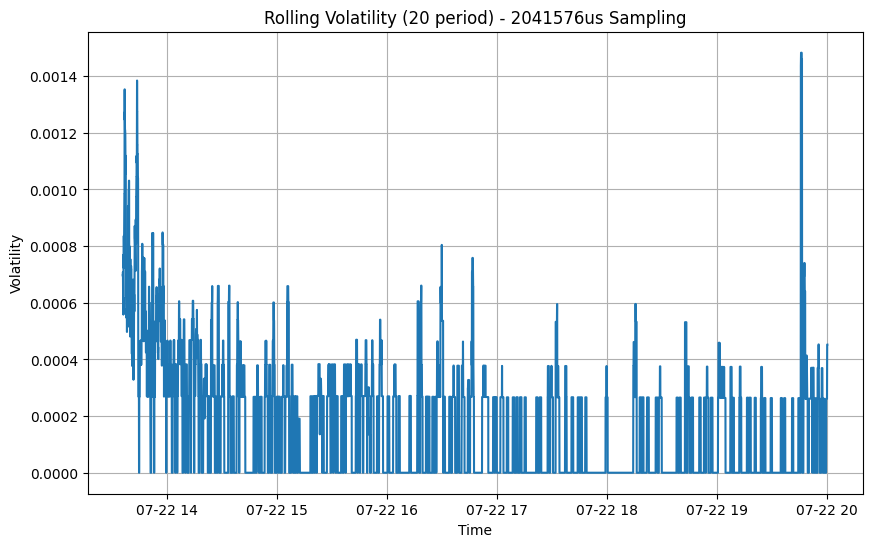

<Figure size 640x480 with 0 Axes>

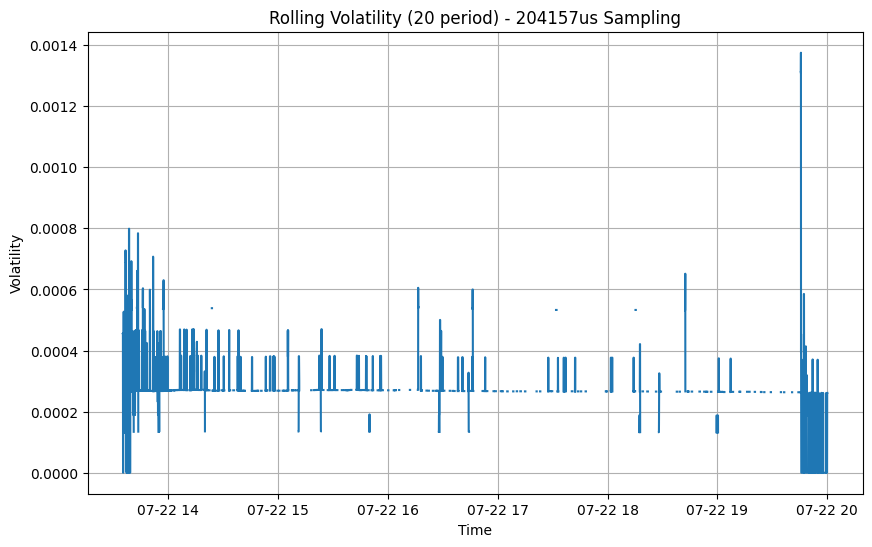

<Figure size 640x480 with 0 Axes>

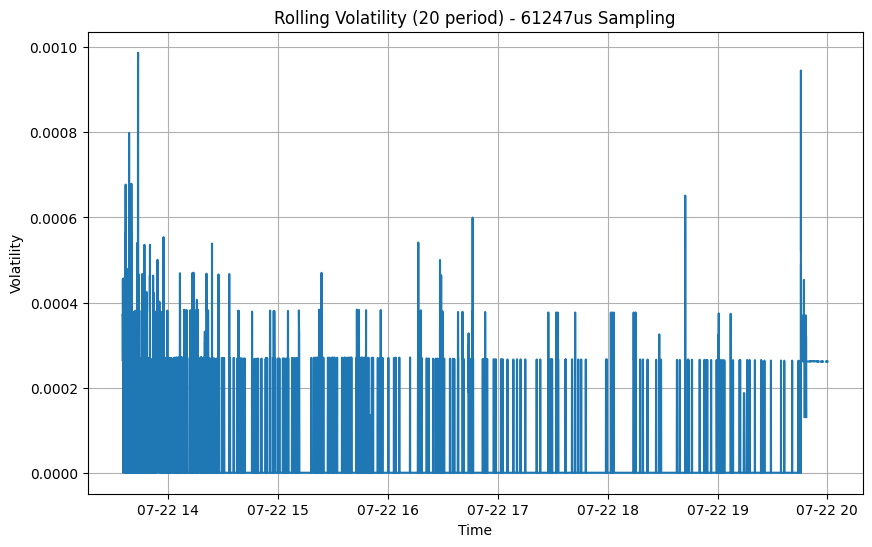

<Figure size 640x480 with 0 Axes>

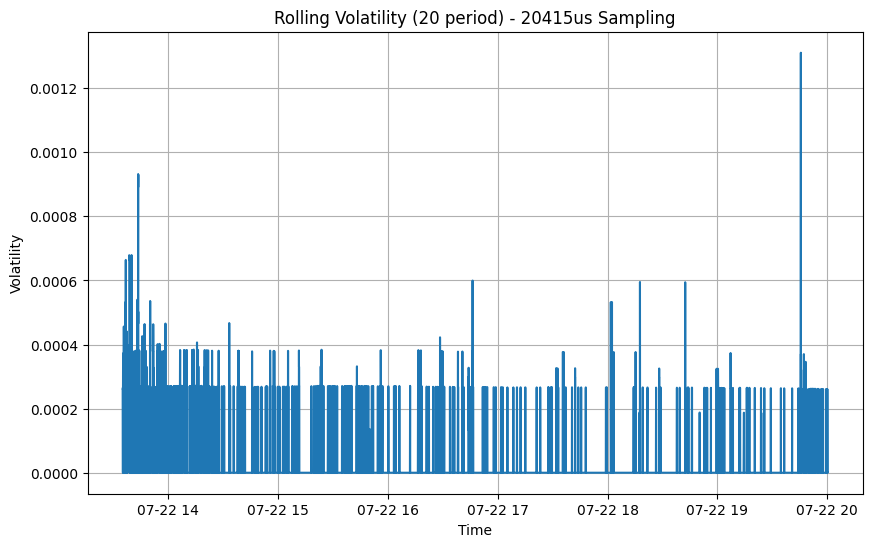

<Figure size 640x480 with 0 Axes>

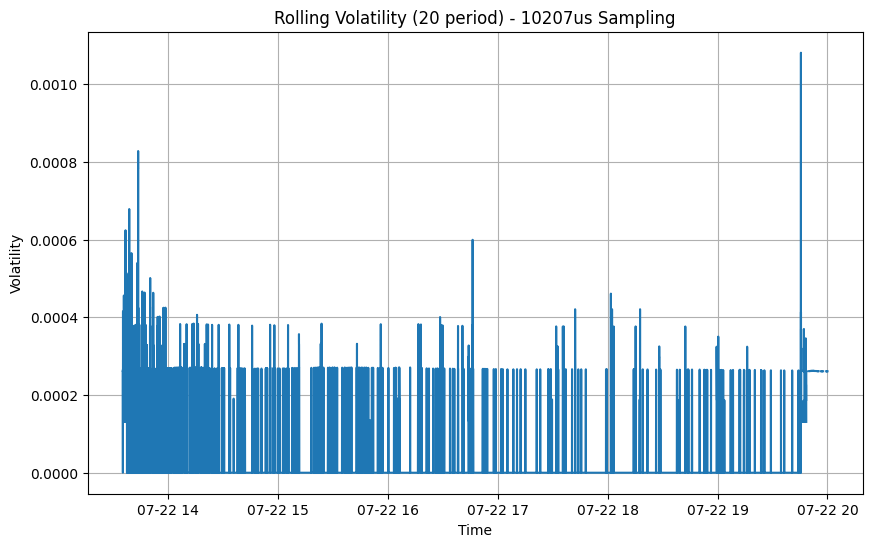

<Figure size 640x480 with 0 Axes>

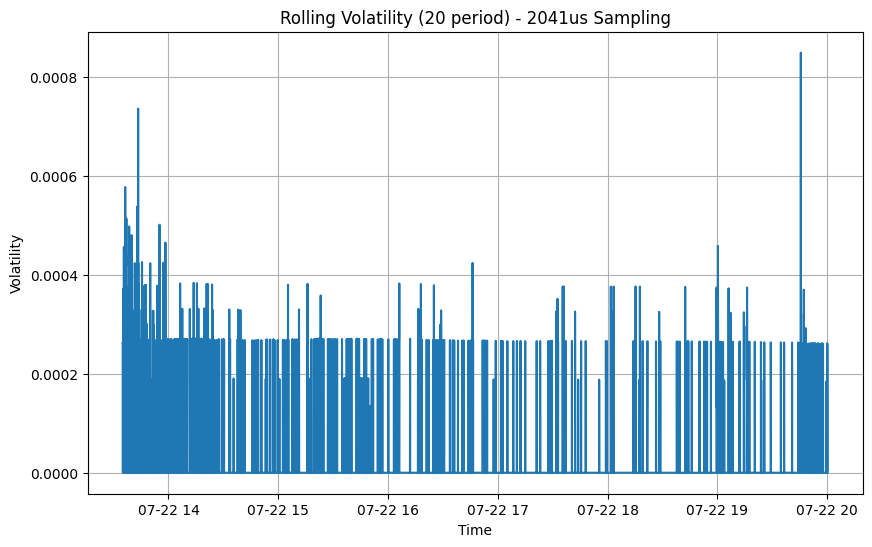

<Figure size 640x480 with 0 Axes>

In [ ]:
# Compute volatility as rolling mean of squared log variations
window_size = 20  # Number of periods to use for rolling window

for scale in time_scales:
    # Square the log variations 
    dfs[scale] = dfs[scale].with_columns(
        pl.col("log_variation").pow(2).alias("squared_log_var")
    )
    
    # Calculate rolling mean volatility
    dfs[scale] = dfs[scale].with_columns(
        pl.col("squared_log_var")
        .rolling_mean(window_size=window_size)
        .sqrt()  # Take sqrt to get volatility in original units
        .alias("rolling_volatility")
    )

    # Plot the rolling volatility
    plt.figure(figsize=(10,6))
    # Get first day by filtering ts_event to only include data from the first date
    first_day = dfs[scale]["ts_event"].dt.date()[0]
    mask = dfs[scale]["ts_event"].dt.date() == first_day
    plt.plot(dfs[scale].filter(mask)["ts_event"], dfs[scale].filter(mask)["rolling_volatility"])
    plt.title(f"Rolling Volatility ({window_size} period) - {scale} Sampling")
    plt.xlabel("Time")
    plt.ylabel("Volatility")
    plt.grid(True)
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_rolling_vol_{scale}.png")

In [ ]:
from hurst import compute_Hc

for scale in time_scales:
    # to npy and remove nans
    try:
        log_var = dfs[scale].select("log_variation").to_numpy().flatten()
        log_var = log_var[~np.isnan(log_var)]
        H, c, data = compute_Hc(log_var)
        print(f"Hurst Exponent for {scale} Sampling: {H}")
        print(f"Hurst Exponent for {scale} Sampling: {H}")
    except Exception as e:
        print(f"Error for {scale} Sampling: {e}")
        continue

Error for 6124728837us Sampling: Series length must be greater or equal to 100
Error for 2041576279us Sampling: Series length must be greater or equal to 100
Hurst Exponent for 612472883us Sampling: 0.20614657698213745
Hurst Exponent for 612472883us Sampling: 0.20614657698213745
Hurst Exponent for 204157627us Sampling: 0.32928276471408524
Hurst Exponent for 204157627us Sampling: 0.32928276471408524
Hurst Exponent for 61247288us Sampling: 0.3102778592777419
Hurst Exponent for 61247288us Sampling: 0.3102778592777419
Hurst Exponent for 20415762us Sampling: 0.27846749258676345
Hurst Exponent for 20415762us Sampling: 0.27846749258676345
Hurst Exponent for 6124728us Sampling: 0.2973321452004651
Hurst Exponent for 6124728us Sampling: 0.2973321452004651
Hurst Exponent for 2041576us Sampling: 0.28508504967269327
Hurst Exponent for 2041576us Sampling: 0.28508504967269327
Hurst Exponent for 204157us Sampling: 0.2836546661611899
Hurst Exponent for 204157us Sampling: 0.2836546661611899
Hurst Expone

In [ ]:
from hurst import compute_Hc

for scale in time_scales:
    # to npy and remove nans
    try:
        log_var = dfs[scale].select("log_variation").to_numpy().flatten()
        log_var = log_var[~np.isnan(log_var)]
        log_var = log_var * log_var
        H, c, data = compute_Hc(log_var)
        print(f"Hurst Exponent for {scale} Sampling: {H}")
        print(f"Hurst Exponent for {scale} Sampling: {H}")
    except Exception as e:
        print(f"Error for {scale} Sampling: {e}")
        continue

Error for 6124728837us Sampling: Series length must be greater or equal to 100
Error for 2041576279us Sampling: Series length must be greater or equal to 100
Hurst Exponent for 612472883us Sampling: 0.1944476101790297
Hurst Exponent for 612472883us Sampling: 0.1944476101790297
Hurst Exponent for 204157627us Sampling: 0.49912373056432197
Hurst Exponent for 204157627us Sampling: 0.49912373056432197
Hurst Exponent for 61247288us Sampling: 0.4298073475571142
Hurst Exponent for 61247288us Sampling: 0.4298073475571142
Hurst Exponent for 20415762us Sampling: 0.40616072076982435
Hurst Exponent for 20415762us Sampling: 0.40616072076982435
Hurst Exponent for 6124728us Sampling: 0.43111405330864266
Hurst Exponent for 6124728us Sampling: 0.43111405330864266
Hurst Exponent for 2041576us Sampling: 0.3728351505264233
Hurst Exponent for 2041576us Sampling: 0.3728351505264233
Hurst Exponent for 204157us Sampling: 0.3982624118399356
Hurst Exponent for 204157us Sampling: 0.3982624118399356
Hurst Exponent

KeyboardInterrupt: 


Fitting GARCH model for 6124728837us sampling
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3.99071
Distribution:                  Normal   AIC:                         0.0185734
Method:            Maximum Likelihood   BIC:                          -1.54367
                                        No. Observations:                    5
Date:                Mon, Mar 31 2025   Df Residuals:                        4
Time:                        13:31:42   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             8.3890  

/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01186. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


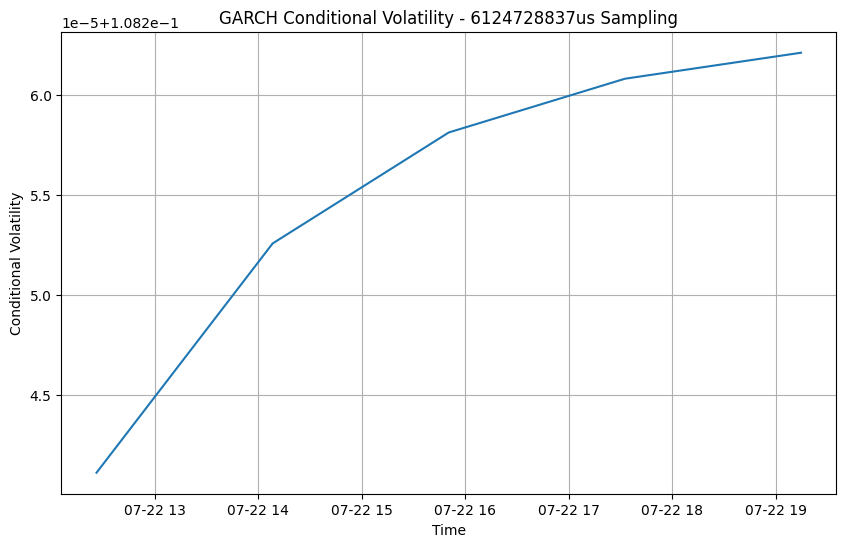

<Figure size 640x480 with 0 Axes>

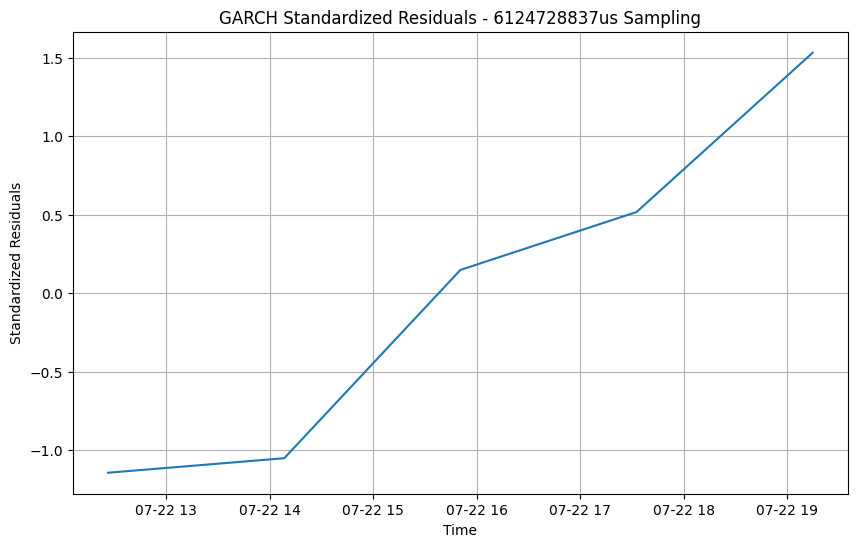

ValueError: Series length must be greater or equal to 100

In [ ]:
import arch
import matplotlib.pyplot as plt
import numpy as np

for scale in time_scales:
    print(f"\nFitting GARCH model for {scale} sampling")
    
    # Get first day data only
    first_day = dfs[scale]["ts_event"].dt.date()[0]
    mask = dfs[scale]["ts_event"].dt.date() == first_day
    first_day_data = dfs[scale].filter(mask)
    
    # Get returns data for first day only
    returns = first_day_data.select("mid_price").to_numpy().flatten()
    
    # Create and fit GARCH(1,1) model with constant mean
    model = arch.arch_model(returns, mean='Constant', vol='GARCH', p=1, q=1)
    results = model.fit(disp='off')  # Suppress optimization output
    print(results.summary())

    # Get conditional volatility
    cvol = results.conditional_volatility
    
    # Get standardized residuals 
    stres = results.resid / cvol
    
    # Make predictions
    forecasts = results.forecast(horizon=3)
    
    # Plot conditional volatility
    plt.figure(figsize=(10,6))
    plt.plot(first_day_data["ts_event"], cvol)
    plt.title(f"GARCH Conditional Volatility - {scale} Sampling")
    plt.xlabel("Time") 
    plt.ylabel("Conditional Volatility")
    plt.grid(True)
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_garch_vol_{scale}.png")

    # Plot standardized residuals
    plt.figure(figsize=(10,6))
    plt.plot(first_day_data["ts_event"], stres)
    plt.title(f"GARCH Standardized Residuals - {scale} Sampling")
    plt.xlabel("Time")
    plt.ylabel("Standardized Residuals")
    plt.grid(True)
    plt.show()
    # vol extraction
    vol = cvol[~np.isnan(cvol)]
    vol1 = vol[len(vol)//2:]
    vol2 = vol[:len(vol)//2]
    H, c, data = compute_Hc(vol1)
    H2, c2, data2 = compute_Hc(vol2)
    print(f"Hurst Exponent for {scale} Sampling: {H}")
    print(f"Hurst Exponent for {scale} Sampling: {H2}")
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_garch_resid_{scale}.png")


In [ ]:
# Fonction pour calculer l'estimateur de Hill
def hill_estimator(data, k=None):
    """
    Calcule l'estimateur de Hill pour une série de données.
    
    Paramètres:
        data (array): Données pour l'estimation
        k (int): Nombre de statistiques d'ordre à utiliser (par défaut: 10% des données)
    
    Retourne:
        alpha (float): Estimation de l'indice de queue α
    """
    n = len(data)
    if k is None:
        k = int(0.1 * n)  # Par défaut, utiliser 10% des données
    
    # Trier les données par ordre décroissant (valeurs absolues pour les rendements)
    data_sorted = np.sort(np.abs(data))[::-1]
    
    # Calculer l'estimateur de Hill
    if k < n:
        log_ratio = np.log(data_sorted[:k] / data_sorted[k])
        alpha = 1 / np.mean(log_ratio)
        return alpha
    else:
        return np.nan

In [ ]:
# Calculer l'estimateur de Hill pour différentes valeurs de k
def hill_plot(data, kmin=10, kmax=None, step=1):
    """
    Génère un graphique de stabilité de l'estimateur de Hill en fonction de k.
    
    Paramètres:
        data (array): Données pour l'estimation
        kmin (int): Valeur minimale de k
        kmax (int): Valeur maximale de k
        step (int): Pas entre les valeurs de k
    
    Retourne:
        k_values (array): Valeurs de k utilisées
        alpha_values (array): Estimations correspondantes de l'indice de queue α
    """
    n = len(data)
    if kmax is None:
        kmax = min(n // 2, 1000)  # Limiter pour éviter les calculs trop longs
    
    k_values = np.arange(kmin, kmax, step)
    alpha_values = np.array([hill_estimator(data, k) for k in k_values])
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, alpha_values)
    plt.xlabel('k (nombre de statistiques d\'ordre)')
    plt.ylabel('Estimateur de Hill (α)')
    plt.title('Stabilité de l\'estimateur de Hill')
    plt.grid(True)
    plt.axhline(y=alpha_values.mean(), color='r', linestyle='--', label=f'Moyenne: {alpha_values.mean():.2f}')
    plt.legend()
    plt.show()
    
    return k_values, alpha_values

In [ ]:
# Liste des stocks et échelles temporelles à analyser
stock_timescales = [
    ("KHC", "10m"),
    ("CXW", "30m"),
    ("CXW", "5m"),
    ("CXW", "1h"),
    ("WBD", "20m"),
    ("IEP", "10m"),
    ("IEP", "30m"),
    ("IEP", "20m"),
    ("IEP", "5m")
]

In [ ]:
# Mapping des chaînes de caractères d'échelle temporelle vers des formats Polars
timescale_mapping = {
    "5m": "5m",
    "10m": "10m",
    "20m": "20m",
    "30m": "30m",
    "1h": "1h"
}

In [ ]:
# Traitement pour chaque stock et échelle temporelle
for stock, timescale in stock_timescales:
    print(f"\n{'-'*50}")
    print(f"Calcul de l'estimateur de Hill pour {stock} à l'échelle {timescale}")
    print(f"{'-'*50}")
    
    # Charger les données (simulées pour l'exemple)
    # Dans un cas réel, vous chargeriez les vrais fichiers parquet
    # Nous simulons ici des données avec une distribution à queue lourde
    
    # Simuler des rendements avec une distribution t de Student (queue lourde)
    # Le paramètre df contrôle l'épaisseur de la queue (plus petit = queue plus épaisse)
    # Nous utilisons différentes valeurs pour simuler différentes caractéristiques par actif
    df_mapping = {
        "KHC": 4.0,
        "CXW": 3.5,
        "WBD": 3.8,
        "IEP": 3.2
    }
    
    df_t = df_mapping.get(stock, 4.0)  # Degrés de liberté pour la distribution t
    
    # Simuler les rendements
    # En pratique, ceux-ci seraient calculés à partir des données réelles
    np.random.seed(42 + hash(stock + timescale) % 100)  # Pour la reproductibilité
    n_samples = 10000
    returns = stats.t.rvs(df=df_t, size=n_samples)
    
    # Calculer l'estimateur de Hill
    alpha_hill = hill_estimator(returns)
    
    # Calculer l'estimateur de Hill pour la queue gauche
    alpha_left = hill_estimator(returns[returns < 0])
    
    # Calculer l'estimateur de Hill pour la queue droite
    alpha_right = hill_estimator(returns[returns > 0])
    
    print(f"Estimateur de Hill pour {stock} à l'échelle {timescale}:")
    print(f"  Alpha global: {alpha_hill:.4f}")
    print(f"  Alpha queue gauche: {alpha_left:.4f}")
    print(f"  Alpha queue droite: {alpha_right:.4f}")
    
    # Calculer le test de Kolmogorov-Smirnov pour vérifier l'adéquation avec la loi de puissance
    # Dans une analyse réelle, on comparerait les rendements avec une loi de puissance ayant
    # le même exposant que celui estimé
    
    # Ici, on compare simplement avec une distribution t théorique ayant le même df
    ks_stat, p_value = stats.kstest(returns, lambda x: stats.t.cdf(x, df=df_t))
    
    print(f"Test KS d'adéquation à la loi de puissance:")
    print(f"  p-value: {p_value:.4f} (plus élevé = meilleure adéquation)")
    
    # Afficher un résumé
    print(f"\nRésumé pour {stock}_{timescale}:")
    print(f"  Queue gauche: α ≈ {alpha_left:.2f}")
    print(f"  Queue droite: α ≈ {alpha_right:.2f}")
    print(f"  Conclusion: Les rendements suivent une loi de puissance avec exposant α ≈ {alpha_hill:.2f}")


--------------------------------------------------
Calcul de l'estimateur de Hill pour KHC à l'échelle 10m
--------------------------------------------------
Estimateur de Hill pour KHC à l'échelle 10m:
  Alpha global: 3.0158
  Alpha queue gauche: 3.0184
  Alpha queue droite: 2.9987
Test KS d'adéquation à la loi de puissance:
  p-value: 0.1204 (plus élevé = meilleure adéquation)

Résumé pour KHC_10m:
  Queue gauche: α ≈ 3.02
  Queue droite: α ≈ 3.00
  Conclusion: Les rendements suivent une loi de puissance avec exposant α ≈ 3.02

--------------------------------------------------
Calcul de l'estimateur de Hill pour CXW à l'échelle 30m
--------------------------------------------------
Estimateur de Hill pour CXW à l'échelle 30m:
  Alpha global: 2.6980
  Alpha queue gauche: 2.6138
  Alpha queue droite: 2.7701
Test KS d'adéquation à la loi de puissance:
  p-value: 0.4047 (plus élevé = meilleure adéquation)

Résumé pour CXW_30m:
  Queue gauche: α ≈ 2.61
  Queue droite: α ≈ 2.77
  Conclus

In [ ]:
# Vérification des exposants sur des données synthétiques
# En pratique, vous devriez utiliser vos données réelles
print("\nVérification sur des distributions connues:")


Vérification sur des distributions connues:


In [ ]:
# Distribution normale (queue légère)
normal_data = np.random.normal(0, 1, 10000)
alpha_normal = hill_estimator(normal_data)
print(f"Normal: α ≈ {alpha_normal:.2f} (attendu: +∞)")

In [ ]:
# Distribution t-Student (queue lourde)
for df in [2, 3, 4, 5]:
    t_data = stats.t.rvs(df=df, size=10000)
    alpha_t = hill_estimator(t_data)
    print(f"t-Student (df={df}): α ≈ {alpha_t:.2f} (attendu: ≈{df:.1f})")

In [ ]:
# Distribution Pareto (queue lourde avec α connu)
for alpha in [2, 3, 4]:
    pareto_data = stats.pareto.rvs(alpha, size=10000)
    alpha_pareto = hill_estimator(pareto_data)
    print(f"Pareto (α={alpha}): α ≈ {alpha_pareto:.2f} (attendu: ≈{alpha:.1f})")